In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind, chi2_contingency

In [2]:
#load data
customers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_customers_dataset.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_orders_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_items_dataset.csv')
order_payments = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_reviews_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist//olist_products_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_sellers_dataset.csv')
category_translation = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/product_category_name_translation.csv')

In [3]:
#first merge product and it's name
products = products.merge(category_translation, on='product_category_name', how='left')

In [ ]:
#1. merge tables
#then merge order and order_items
df = orders.merge(order_items, on='order_id', how='left')
#merge reviews, but only keep review score, will be use later
df = df.merge(order_reviews[['order_id', 'review_score']], on='order_id', how='left')
#merge the payment value
df = df.merge(order_payments[['order_id', 'payment_value']], on='order_id', how='left')
# add customer zip code
df = df.merge(customers[['customer_id', 'customer_zip_code_prefix']], on='customer_id', how='left')
# add seller zip code
df = df.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on='seller_id', how='left')
# add prod category
df = df.merge(products[['product_id', 'product_category_name_english']], on='product_id', how='left')

In [15]:


# =========================
# STEP 1: Prepare base dataframe
# =========================

# Assumes df is your fully merged dataframe with all necessary columns
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# Filter to last 2 years
cutoff_date = df['order_purchase_timestamp'].max() - pd.DateOffset(years=2)
df_recent = df[df['order_purchase_timestamp'] >= cutoff_date]

# =========================
# STEP 2: Focus on health_beauty category
# =========================

df_health = df_recent[df_recent['product_category_name_english'] == 'health_beauty']

# Identify products in this category with multiple sellers
product_seller_counts = df_health.groupby('product_id')['seller_id'].nunique().reset_index()
multi_seller_products = product_seller_counts[product_seller_counts['seller_id'] > 1]['product_id']

# Filter dataset to those products
df_multi_seller = df_health[df_health['product_id'].isin(multi_seller_products)]

# Get customers who bought those products
valid_customers = df_multi_seller[['customer_id']].drop_duplicates()

# Filter full dataset to these customers
df_target = df.merge(valid_customers, on='customer_id', how='inner')

# =========================
# STEP 3: Random group assignment
# =========================

customer_df = df_target[['customer_id']].drop_duplicates()
np.random.seed(42)
customer_df['group'] = np.random.choice(['control', 'test'], size=len(customer_df))
df_target = df_target.merge(customer_df, on='customer_id', how='left')

# =========================
# STEP 4: Feature engineering
# =========================

df_target['shipping_delay'] = (df_target['order_delivered_customer_date'] - 
                               df_target['order_estimated_delivery_date']).dt.days

# Drop missing values
df_clean = df_target.dropna(subset=['review_score', 'shipping_delay', 'payment_value'])

# =========================
# STEP 5: Balance check summary
# =========================

balance_summary = df_clean.groupby('group').agg({
    'review_score': ['mean', 'std', 'count'],
    'shipping_delay': ['mean', 'std', 'count'],
    'payment_value': ['mean', 'std', 'count']
})

print("=== Group Balance Summary ===")
print(balance_summary)

# =========================
# STEP 6: T-tests
# =========================

grouped = df_clean.groupby('group')

review_test = ttest_ind(grouped.get_group('control')['review_score'],
                        grouped.get_group('test')['review_score'],
                        equal_var=False)

delay_test = ttest_ind(grouped.get_group('control')['shipping_delay'],
                       grouped.get_group('test')['shipping_delay'],
                       equal_var=False)

payment_test = ttest_ind(grouped.get_group('control')['payment_value'],
                         grouped.get_group('test')['payment_value'],
                         equal_var=False)

# =========================
# STEP 7: Chi-square test for product category (within health_beauty)
# =========================

contingency = pd.crosstab(df_clean['product_category_name_english'], df_clean['group'])
chi2, p_cat, _, _ = chi2_contingency(contingency)

# =========================
# STEP 8: Output Results
# =========================

print("\n=== T-Test Results (p-values) ===")
print(f"Review Score       : {review_test.pvalue:.4f}")
print(f"Shipping Delay     : {delay_test.pvalue:.4f}")
print(f"Payment Value      : {payment_test.pvalue:.4f}")

print(f"\nProduct Category Distribution p-value: {p_cat:.4f}")

=== Group Balance Summary ===
        review_score                 shipping_delay                  \
                mean       std count           mean       std count   
group                                                                 
control     4.155963  1.324333   763     -11.093054  9.334861   763   
test        4.193548  1.287756   744     -11.323925  8.900749   744   

        payment_value                    
                 mean         std count  
group                                    
control    162.747379  200.260593   763  
test       152.585336  201.533546   744  

=== T-Test Results (p-values) ===
Review Score       : 0.5765
Shipping Delay     : 0.6232
Payment Value      : 0.3264

Product Category Distribution p-value: 0.6202


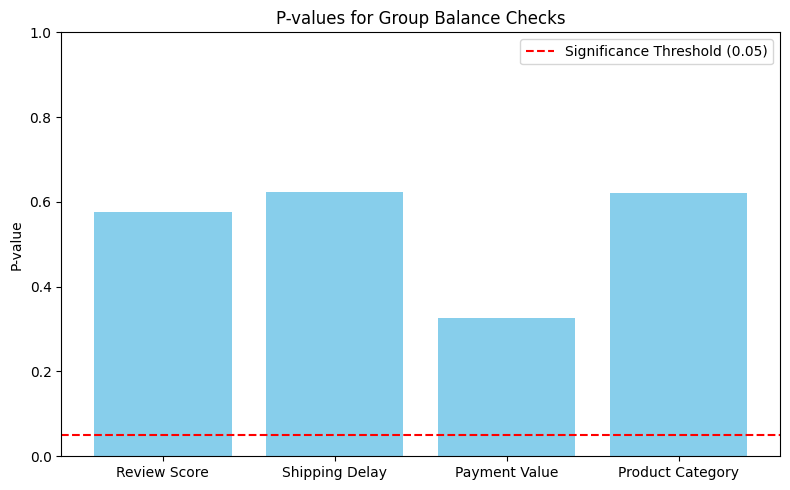

In [16]:
# Create a dictionary of test results
p_values = {
    'Review Score': review_test.pvalue,
    'Shipping Delay': delay_test.pvalue,
    'Payment Value': payment_test.pvalue,
    'Product Category': p_cat
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(p_values.keys(), p_values.values(), color='skyblue')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.title('P-values for Group Balance Checks')
plt.ylabel('P-value')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()